### Plotting Mean+CIs vs. All runs

In [17]:
from ema_workbench import load_results, save_results

In [18]:
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

In [19]:
from plotting import save_fig

In [20]:
sns.set_theme(style="white")

### Set up

In [21]:
no_flood = False # ADJUST HERE

nfl = ""
if no_flood:
    nfl = "no_flood/"

In [22]:
path = f'../results/{nfl}/'
file_ext = '.tar.gz'

In [23]:
file_name_title = '2000_scen' # ADJUST HERE AND THE NEXT LINES TOO
file_name_date = '0612'
file_name_addendum = 'burned_in__with_rates'
N_REPS = 40

In [24]:
fn = '__'.join([file_name_title, f'{N_REPS}_reps', file_name_date, file_name_addendum])
results = load_results(path+fn+file_ext)
full_experiments = results[0]
full_outcomes = results[1]

In [25]:
fn = '__'.join([file_name_title, f'AGGD_reps', file_name_date, file_name_addendum])
results = load_results(path+fn+file_ext)
experiments = results[0]
outcomes = results[1]

In [27]:
# ADJUST HERE: As you wish, e.g. [k for k in outcomes]
oois = ['Household Population', 'GDP', 'Gini Coefficient', 'Median Wage']
# oois.extend([f'Change in {ooi}' for ooi in oois])
oois

['Household Population']

In [28]:
#########################
### NB // ADJUST HERE ###
#########################
# Again, I wish I had saved the representative scenarios as a CSV or something,
#  and then could just read them here.

### WITH FLOODS, K_HP = 3 ###
# representative_scenarios = {
#     'Household Population': [1187, 907, 933],
#     'Gini Coefficient': [485, 1288, 124],
#     'Median Wage': [362, 380],
#     'GDP': [907, 466, 1907, 336],
# }

### WITH FLOODS, K_HP = 6 ###
representative_scenarios = {
    'Household Population': [1625, 740, 161, 1512, 1358, 1337],
    'Gini Coefficient': [485, 1288, 124],
    'Median Wage': [362, 380],
    'GDP': [907, 466, 1907, 336],
}

### NO FLOOD, K_HP = 4 ###
# representative_scenarios = { 
#     'Household Population': [75, 1723, 432, 367],
#     'Gini Coefficient': [375, 1013, 1394],
#     'Median Wage': [1253, 178, 1448, 109],
#     'GDP': [375, 875, 1534, 1570],
# }

### NO FLOOD, K_HP = 7 ###
# representative_scenarios = { 
#     'Household Population': [75, 1723, 1318, 367, 918, 1607, 1633],
#     'Gini Coefficient': [375, 1013, 1394],
#     'Median Wage': [1253, 178, 1448, 109],
#     'GDP': [375, 875, 1534, 1570],
# }


### Optional: Resample (for cleaner plots)

In [29]:
resample = True

In [30]:
if resample:
    resampled_full_outcomes = {}
    for out in full_outcomes:
        resampled_full_outcomes[out] = []
        for arr in full_outcomes[out]:
            resampled_full_outcomes[out].append(arr[::4]) # Sample every year
        resampled_full_outcomes[out] = np.array(resampled_full_outcomes[out])

    resampled_outcomes = {}
    for out in outcomes:
        resampled_outcomes[out] = []
        for arr in outcomes[out]:
            resampled_outcomes[out].append(arr[::4]) # Sample every year
        resampled_outcomes[out] = np.array(resampled_outcomes[out])

    full_outcomes = resampled_full_outcomes
    outcomes = resampled_outcomes

### Plot 1: Variance Convergence

Future: could do this as an animation!

In [ ]:
variance_by_Ns = {ooi:{scen:{} for scen in representative_scenarios[ooi]} for ooi in oois}
for ooi in oois:
    for scenario in representative_scenarios[ooi]:
        # Measure variance with increasing N (replications)
        replications = full_outcomes[ooi][full_experiments[full_experiments.scenario == scenario].index]

        for N in range(2, N_REPS+1):
            reps = replications[:N]
            var = np.var(reps, axis=0, ddof=1)
            variance_by_Ns[ooi][scenario][N] = var

In [ ]:
# Setup for colorbar

normalizer = Normalize(2, N_REPS)
im = cm.ScalarMappable(norm=normalizer)
im.set_cmap('viridis')

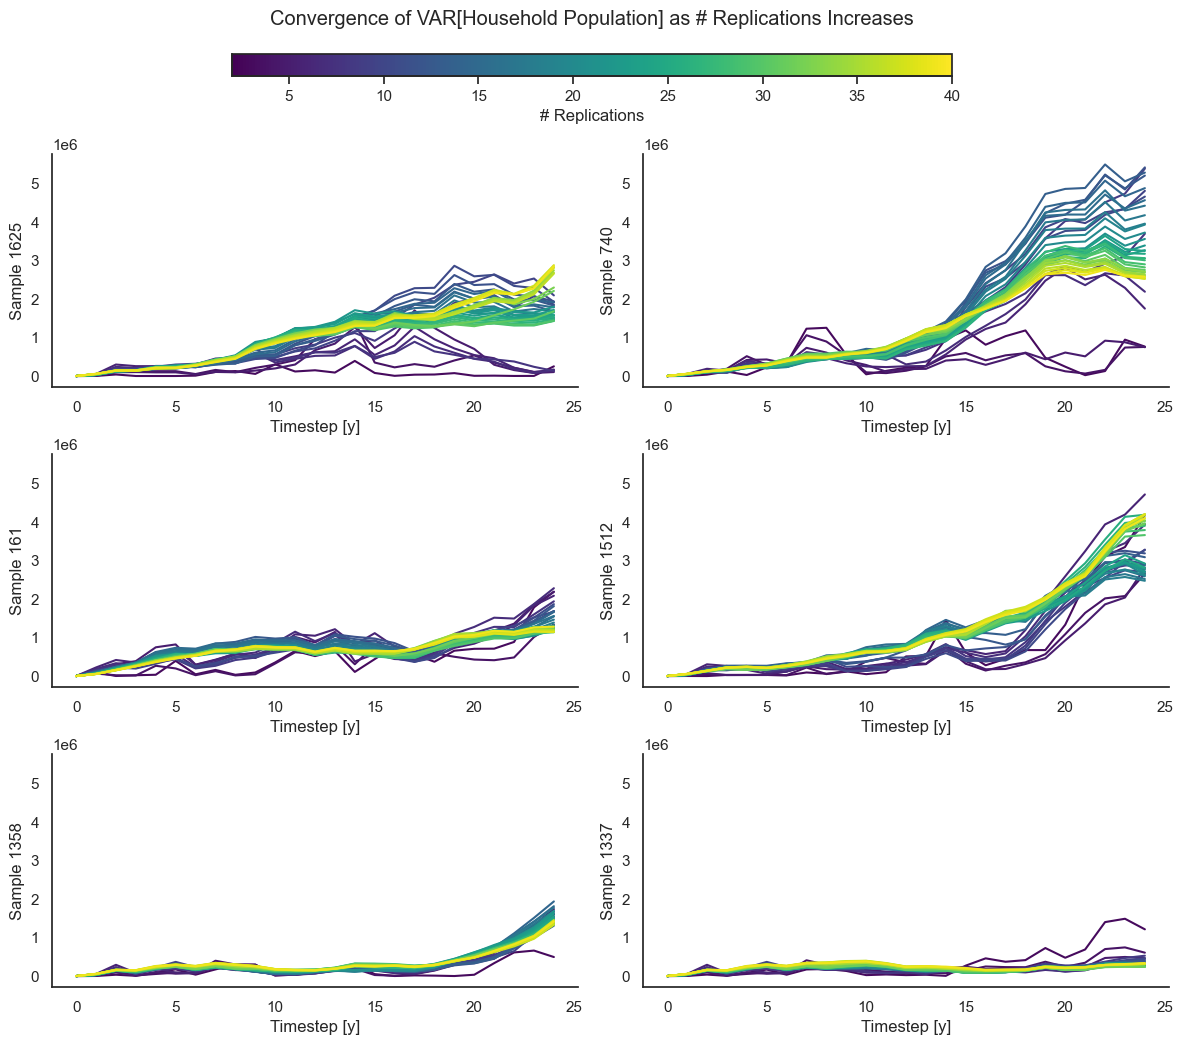

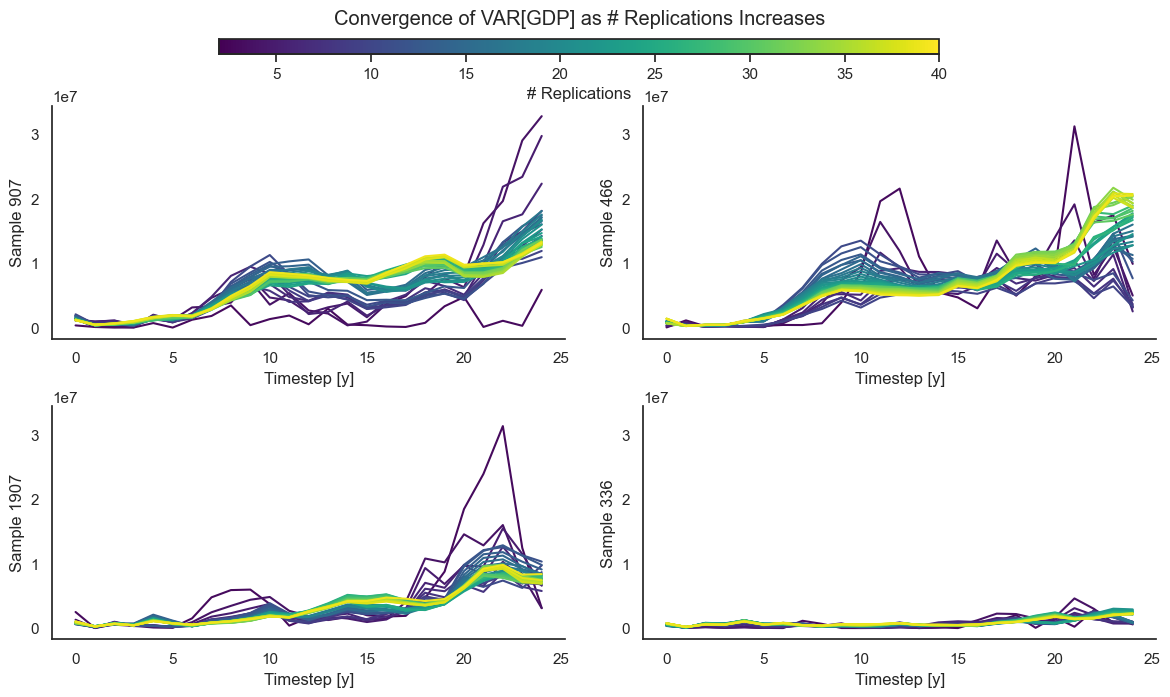

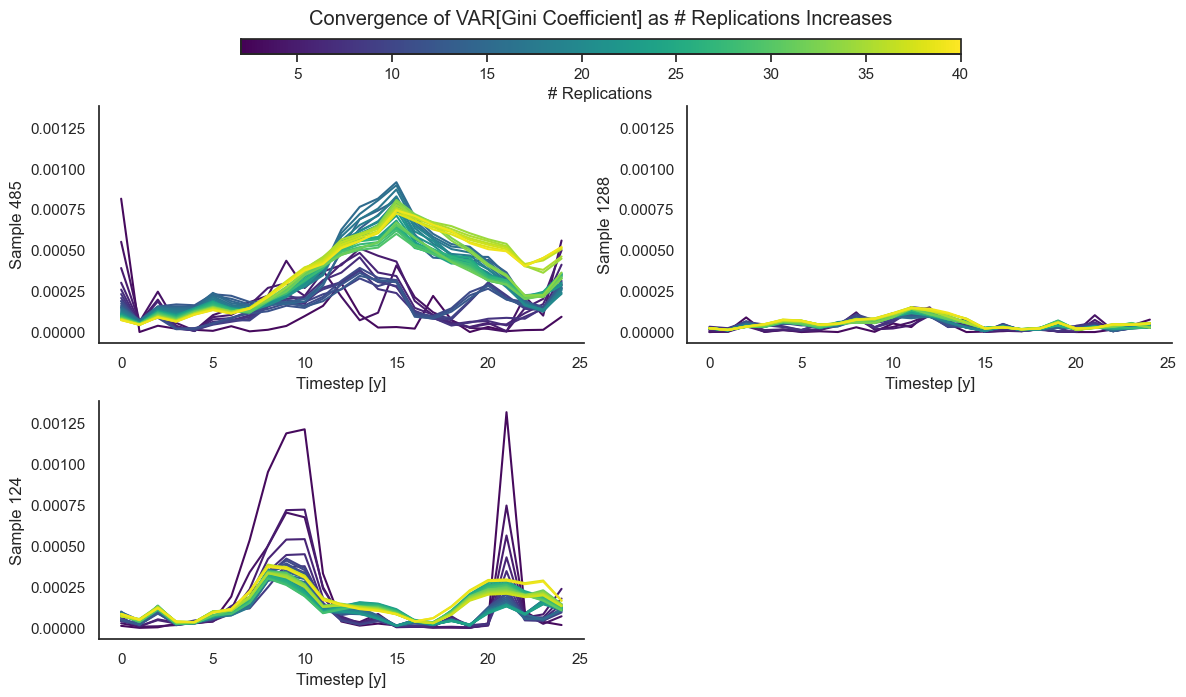

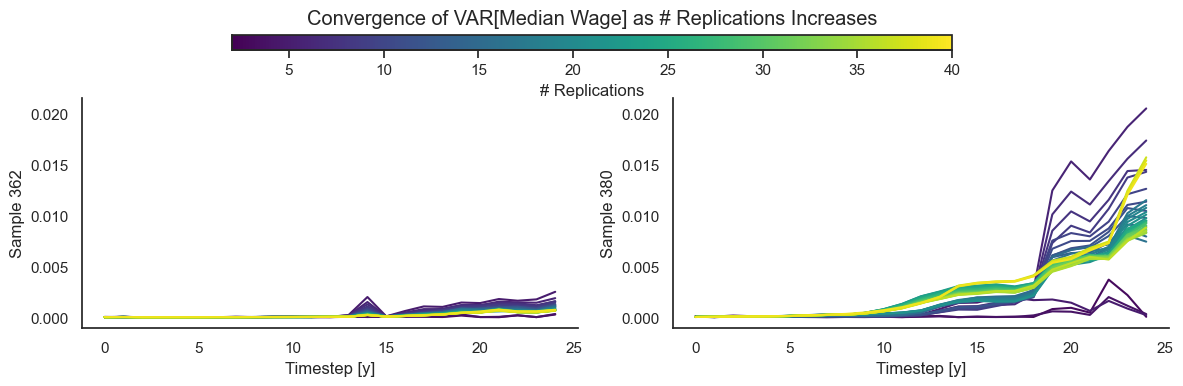

In [ ]:
for ooi in oois:
    # Create subplots
    n_rows = (len(representative_scenarios[ooi])+1)//2
    fig, axes = plt.subplots(n_rows, 2, figsize=(12,3.7*n_rows))
    
    max_y = 0
    for cluster, scenario in enumerate(representative_scenarios[ooi]):
        # Create DF for plotting
        variance_by_N_df = pd.DataFrame(variance_by_Ns[ooi][scenario])

        # Add lines to plot
        if n_rows == 1:
            ax = axes[cluster]
        else:
            row = cluster // 2
            col = cluster % 2
            ax = axes[row][col]

        sns.lineplot(variance_by_N_df,
                     palette='viridis',
                     dashes=False,
                     legend=False,
                     ax=ax)
        
        if resample or 'resampled' in file_name_addendum:
            ax.set_xlabel('Timestep [y]')
        else:
            ax.set_xlabel('Timestep [quarters]')
        ax.set_ylabel(f'Sample {scenario}')

        if ax.get_ylim()[1] > max_y:
            max_y = ax.get_ylim()[1]
    
    # Adjust y-ranges for shared y-axis

    for cluster, scenario in enumerate(representative_scenarios[ooi]):
        if n_rows == 1:
            ax = axes[cluster]
        else:
            row = cluster // 2
            col = cluster % 2
            ax = axes[row][col]
        ax.set_ylim(-max_y/20, max_y)

    # Style figure
    plt.tight_layout()

    # The following (for placement of colorbar) took a lot of manual tweaking.
    # Feel free to tweak further.
    if n_rows == 1:
        top = 0.80
        new_ax_bot = 0.93
        new_ax_height = 0.04
        suptitle_y = 1.04
    elif n_rows == 2:
        top = 0.81
        new_ax_bot = 0.88
        new_ax_height = 0.02
        suptitle_y = 0.94
    elif n_rows == 3:
        top = 0.81
        new_ax_bot = 0.88
        new_ax_height = 0.02
        suptitle_y = 0.94
    elif n_rows == 4:
        top = 0.82
        new_ax_bot = 0.86
        new_ax_height = 0.01
        suptitle_y = 0.89
    
    fig.subplots_adjust(top=top)
    cbar_ax = fig.add_axes([0.2, new_ax_bot, 0.6, new_ax_height])
    cbar = fig.colorbar(im,
                 cax=cbar_ax,
                 ticks=list(range(5, N_REPS+1, 5)),
                 label='# Replications',
                 orientation='horizontal')
    
    if len(representative_scenarios[ooi]) % 2 != 0:
        fig.delaxes(axes[n_rows-1, 1])

    sns.despine()

    save_fig(title=f'{ooi}_ variance convergence', dir=f'{nfl}across_seed_evaluation')
    
    plt.suptitle(f'Convergence of VAR[{ooi}] as # Replications Increases', y=suptitle_y)
    plt.show()

### Plot 2: Mean, CI, Full Timeseries

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


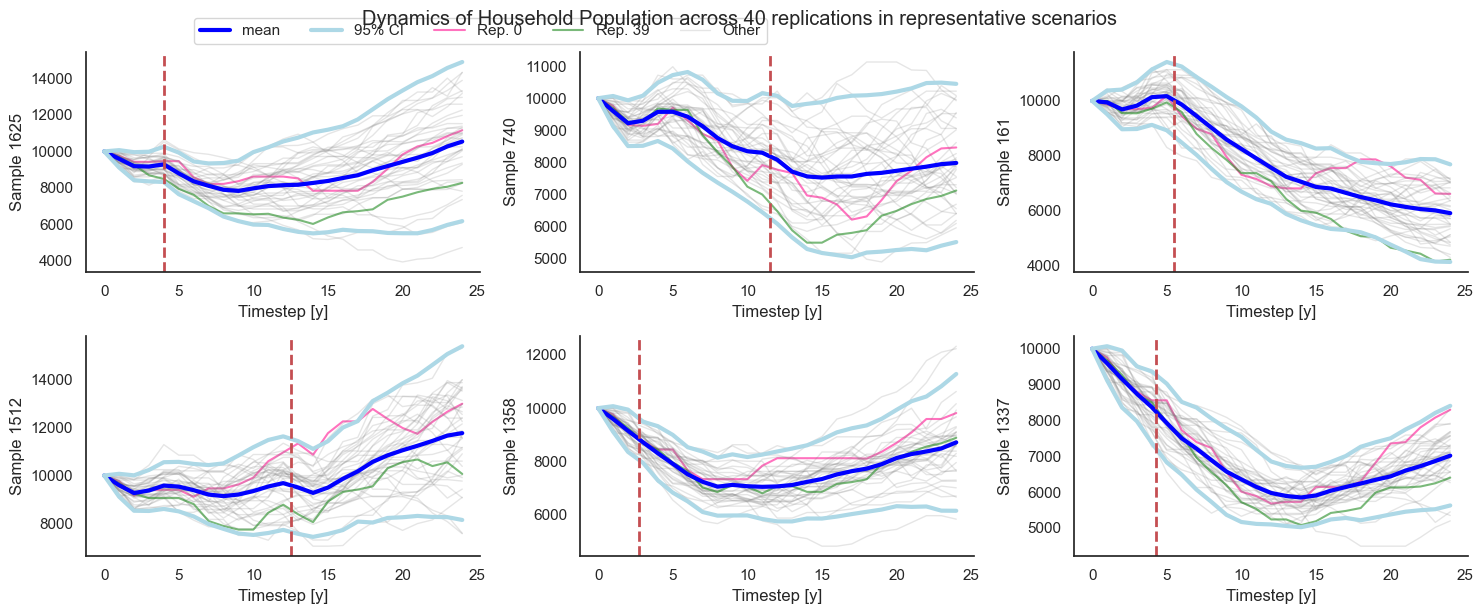

In [35]:
for ooi in oois:
    # Create subplots
    n_cols = 3
    n_rows = (len(representative_scenarios[ooi])+1)//n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols,3*n_rows))

    for cluster, scenario in enumerate(representative_scenarios[ooi]):
        # Select axis
        if n_rows == 1:
            ax = axes[cluster]
        else:
            row = cluster // n_cols
            col = cluster % n_cols
            ax = axes[row][col]

        # Add indiv runs to plot
        replications = full_outcomes[ooi][full_experiments[full_experiments.scenario == scenario].index]
        for n in range(N_REPS):
            # ADJUST HERE: I chose to highlight the first and last replications. You don't have to!
            if n == 0:
                color = (1.0, 0.0784, 0.576, 0.6)
                lw = 1.5
            elif n == N_REPS-1:
                color = (0.133, 0.545, 0.133, 0.6)
                lw = 1.5
            else:
                color = (0.5,0.5,0.5,0.2)
                lw = 1
            ax.plot(replications[n],
                    color=color,
                    #  linestyle='dashed',
                    linewidth=lw) #, label=f'Run {n}')

        # Add aggregated results to plot
        color='blue'
        ax.plot(outcomes[f'{ooi}'][scenario], color=f'{color}',
                linewidth=3)
        ax.plot(outcomes[f'95CI_HI[{ooi}]'][scenario], color=f'light{color}',
                linewidth=3, linestyle='solid')
        ax.plot(outcomes[f'95CI_LO[{ooi}]'][scenario], color=f'light{color}',
                linewidth=3, linestyle='solid')
        
        # Add flood time for current scenario to plot
        flood_time = experiments[experiments.scenario == scenario]['flood_timing'].mean()
        if 'burned_in' in file_name_addendum:
            flood_time -= 20
        if resample or 'resampled' in file_name_addendum:
            flood_time /= 4
        ax.axvline(x=flood_time, color='r', linestyle='--', linewidth=2)

        # Add labels
        if resample or 'resampled' in file_name_addendum:
            ax.set_xlabel('Timestep [y]')
        else:
            ax.set_xlabel('Timestep [quarters]')
        ax.set_ylabel(f'Sample {scenario}')
    
    # Style figure
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Create legend
    ax.legend().set_visible(False)
    handles = [
        Line2D([],[],color=color,linestyle='solid',lw=3,label='mean'),
        Line2D([],[],color=f'light{color}',linestyle='solid',lw=3,label='95% CI'),
        Line2D([],[],color=(1.0, 0.0784, 0.576, 0.6),linestyle='solid',lw=1.5,label='Rep. 0'),
        Line2D([],[],color=(0.133, 0.545, 0.133, 0.6),linestyle='solid',lw=1.5,label='Rep. 39'),
        Line2D([],[],color=(0.5,0.5,0.5,0.2),linestyle='solid',lw=1,label='Other')
    ]
    if n_rows == 1:
        ax = axes[0]
    else:
        ax = axes[0][0]

    legend = ax.legend(
        title=None,
        handles=handles,
        bbox_to_anchor=(1, 1),
        loc='lower center',
        ncol=5,
    )
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((1,1,1,0))
    # legend.get_frame().set_edgecolor((0,0,0,0.2))
    
    if len(representative_scenarios[ooi]) % 2 != 0:
        fig.delaxes(axes[n_rows-1, 1])

    sns.despine()

    if resample or 'resampled' in file_name_addendum:
        save_fig(title=f'{ooi}_ resampled_ across seed dynamics', dir=f'{nfl}across_seed_evaluation')
    else:
        save_fig(title=f'{ooi}_ across seed dynamics', dir=f'{nfl}across_seed_evaluation')

    # Again, feel free to tweak. If it looks ugly in the notebook it might not in the saved figure.
    #  (Also remember that suptitle being after save_fig means the title won't be in that version)
    if n_rows == 1:
        suptitle_y = 1.10
    elif n_rows == 2:
        suptitle_y = 1.02
    elif n_rows == 3:
        suptitle_y = 0.99
        
    plt.suptitle(f'Dynamics of {ooi} across {N_REPS} replications in representative scenarios ', y=suptitle_y)
    plt.show()